In [1]:
from tqdm import tqdm
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
from textblob import TextBlob
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from empath import Empath


In [2]:
# df = pd.read_csv('datasets/verified_features_3k.csv')
df = pd.read_csv('datasets/unverified_features_4k.csv')

In [3]:
# dfs = pd.read_csv('users/verified_features.csv')

In [4]:
# dfs

In [5]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.NUMBER)

In [6]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,...,url,avatar,location,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake
0,14669951,DRUDGE REPORT,2,1378378,21171,237720,1.0,3.0,2.0,2.0,...,http://t.co/dsLXEBfDsQ,https://pbs.twimg.com/profile_images/53808884/...,US,3.0,5.0,2.0,8.0,0.375000,0.250000,0.0
1,1754641,NYT Business,441,786607,14628,207256,0.0,3.0,4.0,4.0,...,http://t.co/OKrfdBy4ch,https://pbs.twimg.com/profile_images/963826250...,"New York, NY",4.0,7.0,3.0,11.0,0.363636,0.272727,0.0
2,24733117,Jeffrey Levin,0,610302,5754,611789,5.0,36.0,20.0,15.0,...,https://t.co/S3UXcXprn9,https://pbs.twimg.com/profile_images/826519476...,"San Jose, CA",25.0,51.0,26.0,76.0,0.328947,0.342105,0.0
3,3863605355,History Lovers Club,0,547308,5048,254351,0.0,6.0,96.0,0.0,...,https://t.co/gggmdpuCSK,https://pbs.twimg.com/profile_images/111175905...,"London, England",96.0,6.0,-90.0,102.0,0.941176,-0.882353,1.0
4,53036660,GLAMOUR South Africa,864,500713,357,36650,0.0,0.0,7.0,5.0,...,https://t.co/3WA7d5ciQJ,https://pbs.twimg.com/profile_images/103042295...,South Africa,7.0,5.0,-2.0,12.0,0.583333,-0.166667,1.0


In [7]:
df = df.drop(['friends', 'created_at', 'url', 'avatar', 'location'], axis = 1)

In [8]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3368 entries, 0 to 3560
Data columns (total 19 columns):
uid                3368 non-null object
name               3368 non-null object
friends_count      3368 non-null object
followers_count    3368 non-null object
listed_count       3368 non-null object
statuses_count     3368 non-null object
pff                3368 non-null float64
pfr                3368 non-null float64
gcf                3368 non-null float64
gcr                3368 non-null float64
description        3368 non-null object
tweets             3368 non-null object
total_fake         3368 non-null float64
total_real         3368 non-null float64
net_trust          3368 non-null float64
total_news         3368 non-null float64
fake_prob          3368 non-null float64
net_trust_norm     3368 non-null float64
fake               3368 non-null float64
dtypes: float64(11), object(8)
memory usage: 526.2+ KB


In [9]:
des = list(df['description'])

In [10]:
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

emoticons = emoticons_happy.union(emoticons_sad)

In [11]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

stop_words = set(stopwords.words('english'))

def clean_tweets(tweet):
    word_tokens = word_tokenize(tweet)
    
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    tweet = emoji_pattern.sub(r'', tweet)
    
    filtered_tweet = []
    
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    
    tweet = ' '.join(filtered_tweet).lower()
    text = ''.join([i if ord(i) < 128 else ' ' for i in tweet])
    
    return " ".join(text.split())

In [12]:
clean_desc = []

for d in des:
    d = str(d)
    d = d.replace("\'s", " ")
    d = d.replace("`", " ")
    d = d.replace("\'", " ")
    d = d.replace("#", "").replace("_", " ")
    d = p.clean(d)
    d = clean_tweets(d)
    clean_desc.append(d)

In [13]:
print('Before: ',des[0])
print()
print('After: ', clean_desc[0])

Before:  The DRUDGE REPORT is a U.S. based news aggregation website run by Matt Drudge(@DRUDGE).

After:  the drudge report u.s. based news aggregation website run matt drudge


In [14]:
df['description'] = clean_desc

In [15]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,description,tweets,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake
0,14669951,DRUDGE REPORT,2,1378378,21171,237720,1.0,3.0,2.0,2.0,the drudge report u.s. based news aggregation ...,ICE Detainer Issued for Suspected Wine Country...,3.0,5.0,2.0,8.0,0.375000,0.250000,0.0
1,1754641,NYT Business,441,786607,14628,207256,0.0,3.0,4.0,4.0,financial tech media business news the new yor...,The morning after the President’s rally in Mis...,4.0,7.0,3.0,11.0,0.363636,0.272727,0.0
2,24733117,Jeffrey Levin,0,610302,5754,611789,5.0,36.0,20.0,15.0,marketing programs manager social media human ...,"""None of this is normal"": read the full transc...",25.0,51.0,26.0,76.0,0.328947,0.342105,0.0
3,3863605355,History Lovers Club,0,547308,5048,254351,0.0,6.0,96.0,0.0,rare historical photos all copyrights belong r...,President Barack Obama and Pope Francis meet f...,96.0,6.0,-90.0,102.0,0.941176,-0.882353,1.0
4,53036660,GLAMOUR South Africa,864,500713,357,36650,0.0,0.0,7.0,5.0,diverse authentic bold,Lady Gaga shows off huge engagement ring at th...,7.0,5.0,-2.0,12.0,0.583333,-0.166667,1.0


In [16]:
tweets = list(df['tweets'])

In [17]:
clean_tweet = []

for tweet in tweets:
    tw = tweet.split('^')
    clean_tw = []

    for d in tw:
        d = str(d)
        d = d.replace("\'s", " ")
        d = d.replace("`", "");
        d = d.replace("\"", "")
        d = d.replace("-", " ")
        d = d.replace("#", "").replace("_", " ")
        d = p.clean(d)
        d = clean_tweets(d)
        clean_tw.append(d)
#         print(clean_tw)
    clean_tweet.append("^".join(clean_tw))

In [18]:
print('Before: ',tweets[0].split("^")[2])
print()
print('After: ', clean_tweet[0].split("^")[2])

Before:  SHOCK VIDEO:  School kids taught to praise Obama... http://tinyurl.com/l3yxmg

After:  shock video school kids taught praise obama ...


In [19]:
df['tweets'] = clean_tweet

In [20]:
# df.head()

In [21]:
df.to_csv("datasets/unverified_features_clean_4k.csv", index = False)

In [22]:
# df = pd.read_csv('users/verified_features_clean.csv')

In [23]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,description,tweets,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake
0,14669951,DRUDGE REPORT,2,1378378,21171,237720,1.0,3.0,2.0,2.0,the drudge report u.s. based news aggregation ...,ice detainer issued suspected wine country ars...,3.0,5.0,2.0,8.0,0.375000,0.250000,0.0
1,1754641,NYT Business,441,786607,14628,207256,0.0,3.0,4.0,4.0,financial tech media business news the new yor...,the morning president rally missouri house com...,4.0,7.0,3.0,11.0,0.363636,0.272727,0.0
2,24733117,Jeffrey Levin,0,610302,5754,611789,5.0,36.0,20.0,15.0,marketing programs manager social media human ...,none normal read full transcript sen. jeff fla...,25.0,51.0,26.0,76.0,0.328947,0.342105,0.0
3,3863605355,History Lovers Club,0,547308,5048,254351,0.0,6.0,96.0,0.0,rare historical photos all copyrights belong r...,president barack obama pope francis meet first...,96.0,6.0,-90.0,102.0,0.941176,-0.882353,1.0
4,53036660,GLAMOUR South Africa,864,500713,357,36650,0.0,0.0,7.0,5.0,diverse authentic bold,lady gaga shows huge engagement ring grammys g...,7.0,5.0,-2.0,12.0,0.583333,-0.166667,1.0


In [24]:
desc = list(df['description'])

In [25]:
desc_sub = []
desc_polar = []

for d in tqdm(desc):
    d = str(d)
    text = TextBlob(d)
    
    desc_sub.append(text.sentiment.subjectivity)
    desc_polar.append(text.sentiment.polarity)    

100%|██████████| 3368/3368 [00:02<00:00, 1349.82it/s]


In [26]:
df['desc_subjectivity'] = desc_sub 
df['desc_polarity'] = desc_polar

In [27]:
df.head(2)

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,...,tweets,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake,desc_subjectivity,desc_polarity
0,14669951,DRUDGE REPORT,2,1378378,21171,237720,1.0,3.0,2.0,2.0,...,ice detainer issued suspected wine country ars...,3.0,5.0,2.0,8.0,0.375000,0.250000,0.0,0.000000,0.000000
1,1754641,NYT Business,441,786607,14628,207256,0.0,3.0,4.0,4.0,...,the morning president rally missouri house com...,4.0,7.0,3.0,11.0,0.363636,0.272727,0.0,0.227273,0.068182


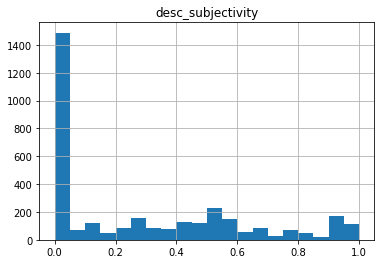

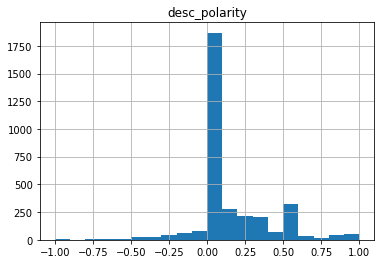

In [28]:
df.hist(column='desc_subjectivity', bins=20)
df.hist(column='desc_polarity', bins=20)

plt.show()

In [29]:
tweets = list(df['tweets'])

tweets_sub = []
tweets_polar = []

for tweet in tqdm(tweets):
    tw = tweet.split("^")
    num = len(tw)
    
    sub_arr = []
    polar_arr = []
    
    for d in tw:

        d = str(d)
        text = TextBlob(d)

        sub_arr.append(text.sentiment.subjectivity)
        polar_arr.append(text.sentiment.polarity)    

    sub = sum(sub_arr)/num
    polar = sum(polar_arr)/num    
    
    tweets_sub.append(sub)
    tweets_polar.append(polar)

100%|██████████| 3368/3368 [02:20<00:00, 23.95it/s] 


In [30]:
df['tweets_subjectivity'] = tweets_sub 
df['tweets_polarity'] = tweets_polar

In [31]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,...,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake,desc_subjectivity,desc_polarity,tweets_subjectivity,tweets_polarity
0,14669951,DRUDGE REPORT,2,1378378,21171,237720,1.0,3.0,2.0,2.0,...,5.0,2.0,8.0,0.375000,0.250000,0.0,0.000000,0.000000,0.125000,-0.012500
1,1754641,NYT Business,441,786607,14628,207256,0.0,3.0,4.0,4.0,...,7.0,3.0,11.0,0.363636,0.272727,0.0,0.227273,0.068182,0.145455,-0.049495
2,24733117,Jeffrey Levin,0,610302,5754,611789,5.0,36.0,20.0,15.0,...,51.0,26.0,76.0,0.328947,0.342105,0.0,0.083333,0.016667,0.376866,0.034605
3,3863605355,History Lovers Club,0,547308,5048,254351,0.0,6.0,96.0,0.0,...,6.0,-90.0,102.0,0.941176,-0.882353,1.0,0.333333,0.100000,0.097059,0.047876
4,53036660,GLAMOUR South Africa,864,500713,357,36650,0.0,0.0,7.0,5.0,...,5.0,-2.0,12.0,0.583333,-0.166667,1.0,0.708333,0.416667,0.336111,0.045833


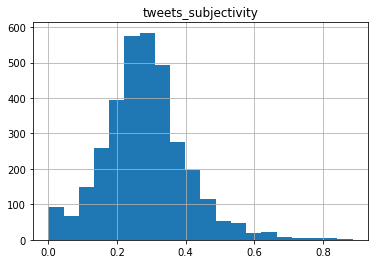

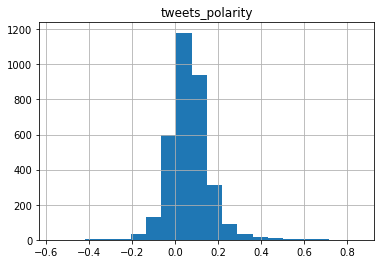

In [32]:
df.hist(column='tweets_subjectivity', bins=20)
df.hist(column='tweets_polarity', bins=20)

plt.show()

In [33]:
lexicon = Empath()

In [34]:
ex = lexicon.analyze(desc[0], normalize=True)

In [35]:
it = list(ex.items())

header = [x for (x,y) in it]

In [36]:
def column_sum(lst):   
    return [sum(i) for i in zip(*lst)] 

In [37]:
ans = []

for tweet in tqdm(tweets):
    tw = tweet.split("^")
    num = len(tw)
    
    arr = []
    
    for d in tw:

        d = str(d)
        if d == "":
            continue
        it = list(lexicon.analyze(d, normalize=True).items())
        emp = [y for (x,y) in it]
        arr.append(emp)
    
    col_sum = column_sum(arr)
    ans.append([x/num for x in col_sum])

100%|██████████| 3368/3368 [40:13<00:00,  3.15it/s]    


In [38]:
# tweets[585].split("^")

In [39]:
len(ans)

3368

In [40]:
len(ans[0])

194

In [41]:
new_head = []

for head in header:
    new_head.append(head + "_empath")

In [42]:
df_empath = pd.DataFrame(ans, columns = new_head) 

In [43]:
df_empath

,help_empath,office_empath,dance_empath,money_empath,wedding_empath,domestic_work_empath,sleep_empath,medical_emergency_empath,cold_empath,hate_empath,...,weapon_empath,children_empath,monster_empath,ocean_empath,giving_empath,contentment_empath,writing_empath,rural_empath,positive_emotion_empath,musical_empath
0,0.000000,0.000000,0.000000,0.000000,0.015625,0.015625,0.000000,0.030357,0.012500,0.000000,...,0.000000,0.015625,0.000000,0.012500,0.031250,0.000000,0.015625,0.000000,0.015625,0.031250
1,0.000000,0.041667,0.000000,0.015152,0.017094,0.056421,0.039755,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.018182,0.000000,0.007576,0.000000,0.033333,0.000000,0.000000,0.000000
2,0.002024,0.017649,0.001096,0.005926,0.009807,0.010276,0.000000,0.005391,0.000000,0.000000,...,0.004151,0.009819,0.000000,0.000000,0.006859,0.000000,0.030271,0.010892,0.002657,0.004582
3,0.000754,0.000000,0.000891,0.000000,0.002451,0.000000,0.000000,0.000000,0.002218,0.000000,...,0.000000,0.016340,0.000000,0.000891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.056807,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.013889,0.000000,0.000000,0.016667,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3363,0.002852,0.000000,0.004998,0.002158,0.011998,0.000000,0.000000,0.000000,0.003274,0.000000,...,0.000000,0.000868,0.000000,0.003460,0.000000,0.000000,0.000000,0.000000,0.001736,0.002841
3364,0.000000,0.006836,0.013221,0.000000,0.030090,0.004058,0.000000,0.002273,0.002778,0.004340,...,0.000000,0.020650,0.002778,0.002500,0.000000,0.000000,0.001563,0.006250,0.004286,0.012179
3365,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005208,0.000000,0.000000,...,0.000000,0.010417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006944,0.000000
3366,0.000000,0.003704,0.002778,0.017500,0.012325,0.003704,0.003704,0.000000,0.000000,0.006061,...,0.003030,0.011364,0.003030,0.000000,0.000000,0.000000,0.006734,0.000000,0.000000,0.002778


In [44]:
cols = ['pff', 'pfr', 'gcf', 'gcr', 'description', 'tweets', 'total_fake',
        'total_real', 'net_trust', 'total_news', 'fake_prob', 'net_trust_norm']

df.drop(cols, axis=1, inplace=True)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3368 entries, 0 to 3560
Data columns (total 11 columns):
uid                    3368 non-null object
name                   3368 non-null object
friends_count          3368 non-null object
followers_count        3368 non-null object
listed_count           3368 non-null object
statuses_count         3368 non-null object
fake                   3368 non-null float64
desc_subjectivity      3368 non-null float64
desc_polarity          3368 non-null float64
tweets_subjectivity    3368 non-null float64
tweets_polarity        3368 non-null float64
dtypes: float64(5), object(6)
memory usage: 315.8+ KB


In [46]:
df_features = pd.concat(
    [
        df, df_empath
    ], axis=1
)

In [47]:
df_features.head(10)

,uid,name,friends_count,followers_count,listed_count,statuses_count,fake,desc_subjectivity,desc_polarity,tweets_subjectivity,...,weapon_empath,children_empath,monster_empath,ocean_empath,giving_empath,contentment_empath,writing_empath,rural_empath,positive_emotion_empath,musical_empath
0,14669951,DRUDGE REPORT,2,1378378,21171,237720,0.0,0.000000,0.000000,0.125000,...,0.000000,0.015625,0.000000,0.012500,0.031250,0.0,0.015625,0.000000,0.015625,0.031250
1,1754641,NYT Business,441,786607,14628,207256,0.0,0.227273,0.068182,0.145455,...,0.000000,0.000000,0.018182,0.000000,0.007576,0.0,0.033333,0.000000,0.000000,0.000000
2,24733117,Jeffrey Levin,0,610302,5754,611789,0.0,0.083333,0.016667,0.376866,...,0.004151,0.009819,0.000000,0.000000,0.006859,0.0,0.030271,0.010892,0.002657,0.004582
3,3863605355,History Lovers Club,0,547308,5048,254351,1.0,0.333333,0.100000,0.097059,...,0.000000,0.016340,0.000000,0.000891,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,53036660,GLAMOUR South Africa,864,500713,357,36650,1.0,0.708333,0.416667,0.336111,...,0.000000,0.000000,0.000000,0.000000,0.013889,0.0,0.000000,0.016667,0.000000,0.000000
5,270106571,Brotips,58,464301,1503,88299,1.0,0.950000,0.750000,0.174709,...,0.006993,0.000000,0.000000,0.004049,0.000000,0.0,0.000000,0.029304,0.000000,0.000000
6,245947377,MTV Teen Mom,20,399873,444,81689,0.0,0.000000,0.000000,0.114803,...,0.000000,0.067488,0.000000,0.007937,0.000000,0.0,0.000000,0.000000,0.000000,0.013743
7,4429003533,Pop Crave,1434,345682,4849,43992,0.0,0.500000,0.500000,0.221731,...,0.008906,0.013997,0.000000,0.000000,0.009584,0.0,0.001626,0.007502,0.005469,0.025090
8,115624161,Yahoo Singapore,500,326246,1202,162682,1.0,0.000000,0.000000,0.196429,...,0.004762,0.040507,0.000000,0.008929,0.000000,0.0,0.000000,0.007143,0.000000,0.016667
9,593615941,t2,1348,294354,142,40330,1.0,0.000000,0.000000,0.328571,...,0.014286,0.014286,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.014286,0.000000


In [48]:
# df_features = pd.read_csv('datasets/verified_features_all_300k.csv')

In [49]:
df_features = df_features.dropna()
# df_features[df_features['uid'] == 936040869878042624]

In [50]:
df_features.to_csv('datasets/unverified_features_all_4k.csv', index=False)

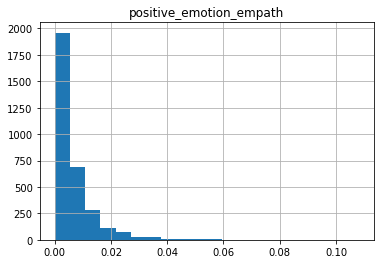

In [51]:
df_features.hist(column='positive_emotion_empath', bins=20)


plt.show()

In [52]:

# df_features.hist(column='friends_count', bins=20)
# df_features.hist(column='followers_count', bins=20)
# df_features.hist(column='listed_count', bins=30)
# df_features.hist(column='statuses_count', bins=30)

# plt.show()

In [53]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3189 entries, 0 to 3367
Columns: 205 entries, uid to musical_empath
dtypes: float64(199), object(6)
memory usage: 5.0+ MB
